In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
#GPU/CPU 선택
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#데이터셋 경로설정
celeba_dir = './data/celeb_tiny/50k'

In [6]:
#데이터셋 클래스 정의
class CelebADataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_name).convert('RGB')   # 이미지를 rgb형식으로 변환
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
#데이터 전처리
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [11]:
celeba_data = CelebADataset(img_dir=celeba_dir, transform=transform)
data_loader = DataLoader(dataset=celeba_data, batch_size=64, shuffle=True)

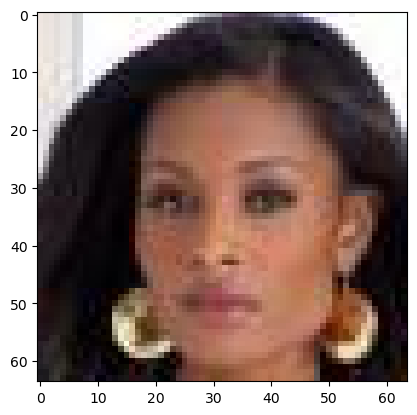

In [15]:
plt.imshow(celeba_data[100].permute(1,2,0))

In [28]:
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(256*4*4, latent_dim) # 평균
        self.fc2 = nn.Linear(256*4*4, latent_dim) # 분산
        self.fc3 = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc1(h), self.fc2(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc3(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [29]:
def loss_function_MSE(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE+KLD

In [30]:
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images)*2,2))
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [36]:
def interpolate_latent_space(model, start, end, steps=10):
    vectors = []
    alpha_values = np.linspace(0,1,steps)
    for alpha in alpha_values:
        vec = (1-alpha) * start + alpha * end
        vectors.append(vec)
    vectors = torch.stack(vectors)
    return vectors

In [32]:
model = VAE(input_channels = 3, hidden_dim=400, latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train(epoch, loss_fn):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_fn(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(data_loader.dataset)}')

In [34]:
loss_fn = loss_function_MSE
for epoch in range(1,11):
    train(epoch, loss_fn)

Epoch 1, Loss: 338.5324201171875
Epoch 2, Loss: 215.46272701660158
Epoch 3, Loss: 202.29297013671874
Epoch 4, Loss: 196.38133499023436
Epoch 5, Loss: 192.9481683642578
Epoch 6, Loss: 190.70196188476564
Epoch 7, Loss: 188.59426788085938
Epoch 8, Loss: 187.36824249023437
Epoch 9, Loss: 186.19709167480468
Epoch 10, Loss: 185.12183267089844


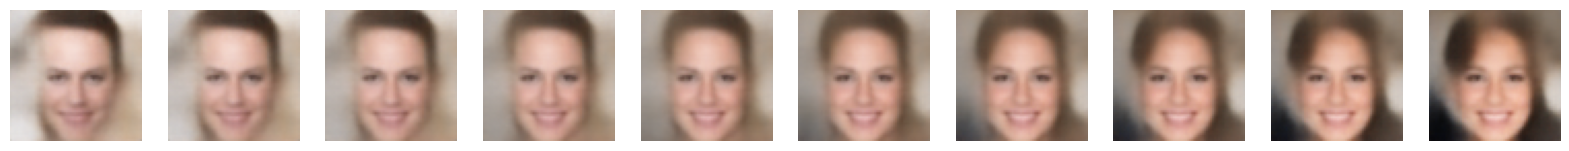

In [39]:
# 두 랜덤 벡터 사이를 보간하여 다양한 스타일의 얼굴 이미지를 생성...
steps = 10
with torch.no_grad():
    z_start = torch.randn(1, 100).to(device)
    z_end = torch.randn(1, 100).to(device)
    interpolated_z = interpolate_latent_space(model, z_start, z_end)
    samples = model.decode(interpolated_z).cpu()
    samples = samples.permute(0,2,3,1).numpy()
    show_images([samples[i] for i in range(steps)])
    torch.cuda.empty_cache()